In [3]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units

import importlib

import snapshot_obj
import simulation_tracing
import dataset_compute
import subhalo
import halo_matching

In [10]:
importlib.reload(snapshot_obj)
importlib.reload(simulation_tracing)
importlib.reload(dataset_compute)
importlib.reload(subhalo)
importlib.reload(halo_matching)

<module 'halo_matching' from '/home/kassiili/Curvaton_Simulations/analysis/halo_matching.py'>

# Plotting trajectories of halos

## Tracing a satellite

In [6]:
sim_id = "V1_LR_fix"
start = 127; stop = 101

First, identify the central halo through snapshots:

In [12]:
gn=1
snap_z0 = snapshot_obj.Snapshot(sim_id, start)
matcher = halo_matching.SubhaloMatcher()
sim_tracer = simulation_tracing.MergerTree(snap_z0, matcher)
sim_trace, snap_ids = sim_tracer.trace_all(stop=100)

127 -> 126: 403694 trials, 778 matches
126 -> 125: 416148 trials, 777 matches
125 -> 124: 413609 trials, 792 matches
124 -> 123: 411364 trials, 786 matches
123 -> 122: 423042 trials, 790 matches
122 -> 121: 415880 trials, 790 matches
121 -> 120: 427833 trials, 782 matches
120 -> 119: 418642 trials, 792 matches
119 -> 118: 431022 trials, 796 matches
118 -> 117: 427247 trials, 791 matches
117 -> 116: 428778 trials, 799 matches
116 -> 115: 434479 trials, 798 matches
115 -> 114: 468416 trials, 788 matches
114 -> 113: 458095 trials, 790 matches
113 -> 112: 415100 trials, 798 matches
112 -> 111: 433195 trials, 790 matches
111 -> 110: 448491 trials, 798 matches
110 -> 109: 465048 trials, 797 matches
109 -> 108: 443629 trials, 810 matches
108 -> 107: 462392 trials, 810 matches
107 -> 106: 456220 trials, 816 matches
106 -> 105: 447309 trials, 818 matches
105 -> 104: 448310 trials, 825 matches
104 -> 103: 452146 trials, 826 matches
103 -> 102: 455702 trials, 822 matches
102 -> 101: 449730 trials

In [14]:
%time central = subhalo.SubhaloTracer(gn, 0, sim_tracer)

CPU times: user 223 ms, sys: 20.1 ms, total: 243 ms
Wall time: 242 ms


Then, select a satellite that can be traced back through a couple snapshots (for instance, the M31 satellite (1,4)):

In [28]:
sgn=2
%time satellite = subhalo.SubhaloTracer(gn, sgn, sim_tracer)

CPU times: user 280 ms, sys: 32 ms, total: 312 ms
Wall time: 317 ms


In [29]:
%time d = satellite.distance_to_central(central)
d = d * units.cm.to(units.kpc)

CPU times: user 3.72 s, sys: 236 ms, total: 3.96 s
Wall time: 3.96 s


Compute the distance between the central and the satellite:

Plot in the xy- and xz-plane:

/home/kassiili/Curvaton_Simulations/analysis/Figures/V1_LR_fix


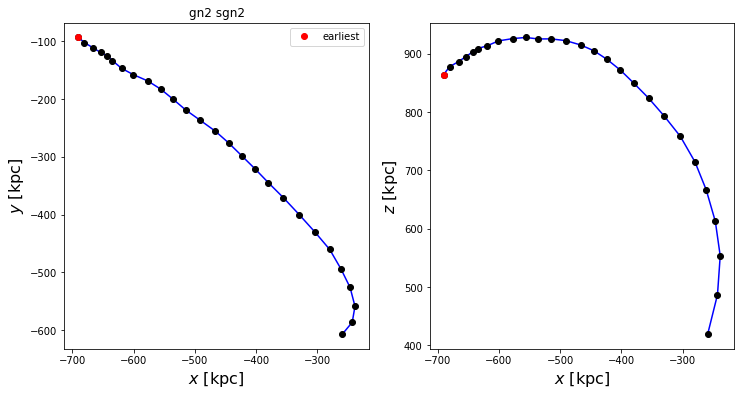

In [30]:
fig,ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].plot(d[:,0], d[:,1], 'b')
ax[0].plot(d[:,0], d[:,1], 'ko')
ax[0].plot(d[0,0], d[0,1], 'ro', label='earliest')
ax[0].set_xlabel('$x$ [kpc]', fontsize=16)
ax[0].set_ylabel('$y$ [kpc]', fontsize=16)

ax[1].plot(d[:,0], d[:,2], 'b')
ax[1].plot(d[:,0], d[:,2], 'ko')
ax[1].plot(d[0,0], d[0,2], 'ro')
ax[1].set_xlabel('$x$ [kpc]', fontsize=16)
ax[1].set_ylabel('$z$ [kpc]', fontsize=16)

ax[0].legend()

# Save figure:

filename = 'satellite_trajectory_gn{}sgn{}_{}.png'.format(gn,sgn,sim_id)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures",sim_id)
print(path)

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)

# Plot evolution of mass components

In [31]:
z = sim_tracer.get_redshifts()

In [32]:
masses = satellite.get_halo_data("MassType") * units.g.to(units.Msun)

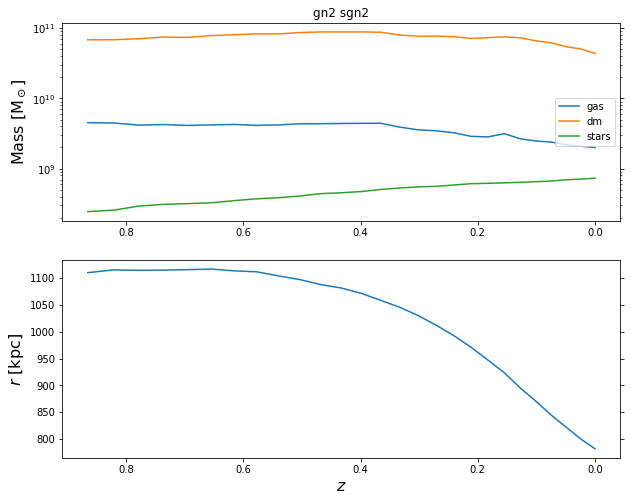

In [33]:
fig,ax = plt.subplots(nrows=2, figsize=(10,8))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].set_yscale('log')
ax[0].set_ylabel('Mass $[\mathrm{M_\odot}]$', fontsize=16)

ax[1].set_xlabel('$z$', fontsize=16)
ax[1].set_ylabel('$r$ [kpc]', fontsize=16)

ax[0].yaxis.set_ticks_position('both')
ax[1].yaxis.set_ticks_position('both')

ax[0].invert_xaxis()
ax[1].invert_xaxis()

for pt,l in zip([0,1,4],['gas', 'dm', 'stars']):
    ax[0].plot(z, masses[:,pt], label=l)
    
ax[0].legend()

ax[1].plot(z, np.linalg.norm(d, axis=1))

# Save figure:

filename = 'satellite_mass_evol_gn{}sgn{}_{}.png'.format(gn,sgn,sim_id)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures",sim_id)

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)